In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

# Hypothesis testing: Chi-Square Test within the Eniac case study

In this notebook we perform a chi-square test with the data from the Eniac case study, applying a post-hoc correction to perform pairwise tests and find the true winner.

## 1.&nbsp;State the Null Hypothesis and the Alternative Hypothesis.

--**Null Hypothesis:** The 4 versions of the button are equally likely to receive clicks

--**Alternative Hypothesis:** There is at least one version that got so many more/much less clicks than the others

# solution
Null Hypothesis ($H_0$): The click-through rate for all versions of the website is equal.

Alternative Hypothesis ($H_A$): The click-through rate for at least one version of the website differs.

## 2.&nbsp; Select an appropriate significance level alpha ($\alpha$).

It was decided that a relatively high alpha was acceptable in this case

In [5]:
alpha = 0.05

## 3.&nbsp; Collect data that is random and independent

The important pieces of information (clicks on each element of interest & visits on each page) are scattered around. Let's collect them. Where are the .csv files? 🥸

In [7]:
# Eniac_a.csv
url = "https://drive.google.com/file/d/1sD3TIBX-hYo7Ago-IcUmjSDrxMz6qikR/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
eniac_a_df = pd.read_csv(path)

url = "https://drive.google.com/file/d/1Sw0KtRsZUATts5_5XHVPUEVmOmaZqr41/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
eniac_b_df = pd.read_csv(path)

url = "https://drive.google.com/file/d/1CeZAWk8CjpwuQLwDepDpZw6dctfdj7n4/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
eniac_c_df = pd.read_csv(path)

url = "https://drive.google.com/file/d/10416vwDmtvUnWZ9bbsk8azb5c3bvYA02/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
eniac_d_df = pd.read_csv(path)

## 4.&nbsp; Calculate the test result

In [8]:
eniac_a_clicks = eniac_a_df.loc[eniac_a_df["Name"]=="SHOP NOW", "No. clicks"].iloc[0]
eniac_b_clicks = eniac_b_df.loc[eniac_b_df["Name"]=="SHOP NOW", "No. clicks"].iloc[0]
eniac_c_clicks = eniac_c_df.loc[eniac_c_df["Name"]=="SEE DEALS", "No. clicks"].iloc[0]
eniac_d_clicks = eniac_d_df.loc[eniac_d_df["Name"]=="SEE DEALS", "No. clicks"].iloc[0]

In [9]:
eniac_a_df.iloc[1, -1]

'created 2021-09-14   •   14 days 0 hours 34 mins   •   25326 visits, 23174 clicks'

In [10]:
eniac_a_visits = 25326
eniac_b_visits = 24747
eniac_c_visits = 24876
eniac_d_visits = 25233

In [11]:
eniac_a_no_click = eniac_a_visits - eniac_a_clicks
eniac_b_no_click = eniac_b_visits - eniac_b_clicks
eniac_c_no_click = eniac_c_visits - eniac_c_clicks
eniac_d_no_click = eniac_d_visits - eniac_d_clicks

In [12]:
#  make a contingency tabl
clicks = [eniac_a_clicks, eniac_b_clicks, eniac_c_clicks, eniac_d_clicks]
noclicks = [eniac_a_no_click, eniac_b_no_click, eniac_c_no_click, eniac_d_no_click]

observed_results = pd.DataFrame(data = [clicks, noclicks],
                                columns = ["Version_A", "Version_B", "Version_C", "Version_D"],
                                index = ["Click", "No-click"])

observed_results

,Version_A,Version_B,Version_C,Version_D
Click,512,281,527,193
No-click,24814,24466,24349,25040


In [13]:
chisq, pvalue, df, expected = stats.chi2_contingency(observed_results)

In [14]:
pvalue

np.float64(2.7161216607868712e-48)

## 5.&nbsp; Interpret the test result

In [15]:
if pvalue > alpha:
    print("Do not reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Reject the null hypothesis


This means that at least one of the four different versions performed significantly better or worse than the others.

## How do we decide who's the winner?

In [97]:
# post hoc test

> **In brief:** Post hoc tests, also known as post hoc comparisons or pairwise comparisons, are statistical procedures used in conjunction with a Chi-Squared test to determine specific differences between groups or conditions after obtaining significant results from the Chi-Squared test. Once the Chi-Squared test reveals a significant difference among the variables being examined, post hoc tests are employed to identify which specific groups or categories are significantly different from each other.

We have 6 possible dual tests to perform:
* Version A - Version B
* Version A - Version C
* Version A - Version D
* Version B - Version C
* Version B - Version D
* Version C - Version D

The level of alpha we selected for the chi-squared test cannot be same for the dual tests. If there was an error of 5% in each of the tests, this would sum up to much more than the 5% total we set for alpha, so we will need to be much more restrictive in the dual tests. Therefore, we will split the value of alpha equally among the dual tests to be performed.

In [16]:
possible_combinations = 6
alpha_post_hoc = alpha / possible_combinations
alpha_post_hoc

0.008333333333333333

In [17]:
# click-through rates
eniac_a_ctr = eniac_a_clicks / eniac_a_visits
eniac_b_ctr = eniac_b_clicks / eniac_b_visits
eniac_c_ctr = eniac_c_clicks / eniac_c_visits
eniac_d_ctr = eniac_d_clicks / eniac_d_visits

# display as DataFrame
rates = [eniac_a_ctr, eniac_b_ctr, eniac_c_ctr, eniac_d_ctr]
names = ["Version_A", "Version_B", "Version_C", "Version_D"]

ctr_df = pd.DataFrame({"rates": rates, "names": names})
ctr_df.sort_values("rates", ascending=False)

,rates,names
2,0.021185,Version_C
0,0.020216,Version_A
1,0.011355,Version_B
3,0.007649,Version_D


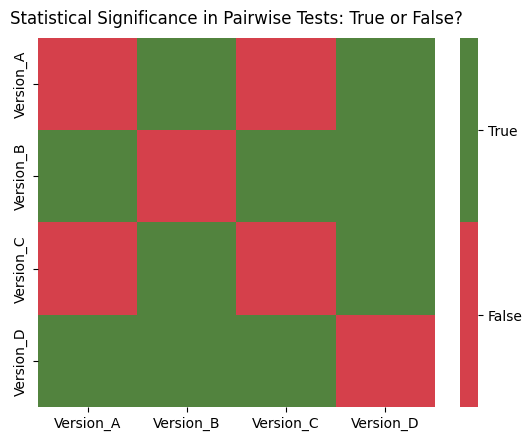

In [18]:
# empty dictionary to fill with our results
stat_significant_dict = {
                        "Version_A": [],
                        "Version_B": [],
                        "Version_C": [],
                        "Version_D": []
                         }

# compare each version to each other version
for i in observed_results.columns:
  for j in observed_results.columns:
    # use scipy to find the p-value of each pair
    chisq, pvalue, df, expected = stats.chi2_contingency(observed_results.loc[:, [i, j]], correction=False)
    # boolean: if the p-value is lower than alpha, our result is statistically significant
    stat_significant_dict[i].append(pvalue < alpha_post_hoc)

# create a DataFrame of results
stat_significant_df = pd.DataFrame(stat_significant_dict,
                                   index=observed_results.columns)

# create a heatmap from the DataFrame & red/green colour palette
red_green_palette = sns.diverging_palette(10, 120, n=2, s=70, l=50)
ax = sns.heatmap(stat_significant_df, cmap=red_green_palette)

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['False', 'True'])

# Add a title to the heatmap
ax.set_title("Statistical Significance in Pairwise Tests: True or False?", pad=10);

In [19]:
stat_significant_df

,Version_A,Version_B,Version_C,Version_D
Version_A,False,True,False,True
Version_B,True,False,True,True
Version_C,False,True,False,True
Version_D,True,True,True,False


Analysing our heatmap, it is evident that the version with the highest click-through rate, `Version_C`, exhibits a statistically significant difference when compared Versions B and D, but not to `Version_A`, which possesses the second-highest click-through rate. As a result, declaring a clear winner based on post hoc tests becomes challenging, therefore we can only say that both `Version_C` and `Version_A` are the winners.

However, if a definitive winner is required, additional steps need to be implemented. This is where we transition from the realm of statistics to the business world. The following actions can help in determining the version to be featured on the website in the future:
 - Consider other metrics alongside click-through rate.
 - Incorporate qualitative research findings.
 - Seek input from subject-matter experts.
 - Redesign the experiment and conduct it once more.